In [3]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [4]:
# Load the CSV file using Pandas
data = pd.read_csv('preproc_data.csv')
data_f  = data.groupby('Label', group_keys=False).apply(lambda data: data.sample(20000))
print(data_f.shape)
print(f"{data_f['Label'].value_counts()}\n")
data_f = data_f.sample(frac=1)
data_f.head()
label_encoder = LabelEncoder()
data_f['Label']= label_encoder.fit_transform(data_f['Label'])
data_f['Label'] = data_f['Label'].astype('int64')
# Split features and labels
features = data_f.drop('Label', axis=1)  # Adjust 'label_column_name' to the column name of your labels
labels = data_f['Label']

(40000, 44)
attack    20000
normal    20000
Name: Label, dtype: int64



In [5]:
data_f.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Min,Bwd Pkt Len Max,...,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Active Mean,Active Std,Idle Mean,Idle Std,Label
634973,0.00097,0.0,0.04491,0.00028,0.125,0.0,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
566686,0.00097,0.0,0.04681,0.00137,0.125,0.0,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
393146,0.00097,0.0,0.04542,0.00370,0.125,0.0,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
351506,0.00097,0.0,0.04474,0.00019,0.125,0.0,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
309048,0.66896,0.0,0.04710,0.33739,0.500,0.3,0.56461,0.15946,0.0,0.40779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [6]:
# Convert data to PyTorch tensors
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, train_size=0.7, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, stratify=y_temp)

In [7]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create PyTorch data loaders
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [8]:
import torch.nn as nn

# Define the model for binary classification with 43 input features
model = nn.Sequential(
    nn.Linear(43, 64),  # Adjust input size to match the number of features in your data
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(32, 2)  # Adjust output size for binary classification (2 classes)
)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
sample_input = torch.ones((4, 43))  # Creating a tensor for a batch of 4 samples, each with 43 features

# Getting the output tensor dimensions
output = model(sample_input)
print(output.shape)

torch.Size([4, 2])


In [107]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define the device

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = []
    accuracy_hist_train = []
    loss_hist_valid = []
    accuracy_hist_valid = []

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * y_batch.size(0)
            _, predicted = torch.max(pred, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()

        epoch_train_loss /= len(train_dl.dataset)
        accuracy_train = correct_train / total_train

        loss_hist_train.append(epoch_train_loss)
        accuracy_hist_train.append(accuracy_train)

        model.eval()
        epoch_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)

                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)

                epoch_val_loss += loss.item() * y_batch.size(0)
                _, predicted = torch.max(pred, 1)
                total_val += y_batch.size(0)
                correct_val += (predicted == y_batch).sum().item()

        epoch_val_loss /= len(valid_dl.dataset)
        accuracy_val = correct_val / total_val

        loss_hist_valid.append(epoch_val_loss)
        accuracy_hist_valid.append(accuracy_val)

        print(f'Epoch {epoch + 1} | Train Loss: {epoch_train_loss:.4f} | Train Accuracy: {accuracy_train:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {accuracy_val:.4f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [11]:
torch.manual_seed(1)
num_epochs = 10
model.to(DEVICE)
hist = train(model,num_epochs,train_dl,valid_dl)

Epoch 1 | Train Loss: 0.2075 | Train Accuracy: 0.9571 | Val Loss: 0.0050 | Val Accuracy: 0.9987
Epoch 2 | Train Loss: 0.0060 | Train Accuracy: 0.9991 | Val Loss: 0.0008 | Val Accuracy: 1.0000
Epoch 3 | Train Loss: 0.0030 | Train Accuracy: 0.9998 | Val Loss: 0.0003 | Val Accuracy: 1.0000
Epoch 4 | Train Loss: 0.0021 | Train Accuracy: 0.9999 | Val Loss: 0.0001 | Val Accuracy: 1.0000
Epoch 5 | Train Loss: 0.0016 | Train Accuracy: 0.9999 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 6 | Train Loss: 0.0011 | Train Accuracy: 1.0000 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 7 | Train Loss: 0.0010 | Train Accuracy: 1.0000 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 8 | Train Loss: 0.0006 | Train Accuracy: 0.9999 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 9 | Train Loss: 0.0009 | Train Accuracy: 1.0000 | Val Loss: 0.0000 | Val Accuracy: 1.0000
Epoch 10 | Train Loss: 0.0006 | Train Accuracy: 1.0000 | Val Loss: 0.0000 | Val Accuracy: 1.0000


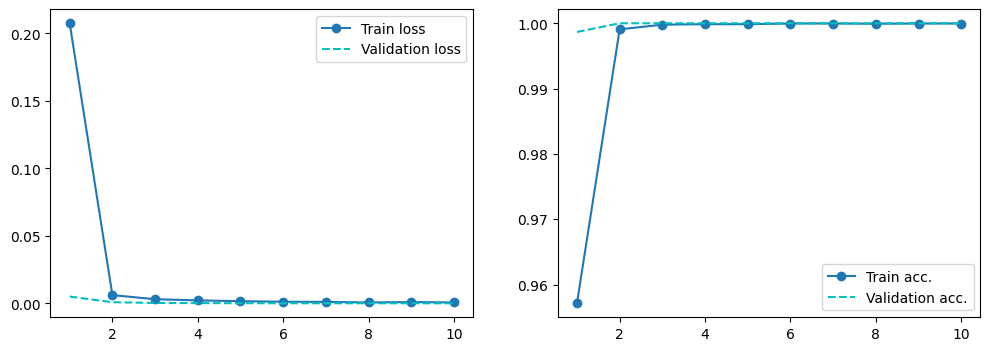

In [12]:
import numpy as np
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr,hist[0],'-o',label='Train loss')
ax.plot(x_arr,hist[1],'--c',label='Validation loss')
plt.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr,hist[2],'-o',label='Train acc.')
ax.plot(x_arr,hist[3],'--c',label='Validation acc.')
plt.legend()
plt.show()

In [13]:
def test(model, test_dl):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define the device

    truelabels = []
    predictions = []

    model.eval()
    with torch.no_grad():
        for data, target in test_dl:
            data = data.to(DEVICE)
            target = target.to(DEVICE)

            for label in target.cpu().numpy():
                truelabels.append(label)

            output = model(data)
            _, predicted = torch.max(output, 1)
            for prediction in predicted.cpu().numpy():
                predictions.append(prediction)

    truelabels = np.array(truelabels)
    predictions = np.array(predictions)

    total = len(truelabels)
    correct = (predictions == truelabels).sum().item()

    accuracy = 100. * (correct / total)
    return accuracy


In [14]:
test(model,test_dl)

100.0

In [15]:
torch.save(model,'model.pth')

In [16]:
model = torch.load('model.pth')

In [17]:
import copy
model_m = copy.deepcopy(model)
model_s = copy.deepcopy(model)

In [18]:
import torch.distributions
import torch.nn.functional as F

In [19]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc_mean = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder layers
        self.fc2 = nn.Linear(latent_dim, 256)
        self.fc3 = nn.Linear(256, input_dim)

    def encode(self, x):
        x = F.leaky_relu(self.fc1(x))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def decode(self, z):
        z = F.leaky_relu(self.fc2(z))
        z = torch.sigmoid(self.fc3(z))
        return z

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar

    def loss_function(self, x_recon, x, mean, logvar):
        recon_loss = F.mse_loss(x_recon, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        return recon_loss + kl_div


In [20]:
vae = VAE(input_dim=43, latent_dim=10)

optimizer = torch.optim.Adam(vae.parameters(),lr=0.001)
num_epochs=20

In [21]:
vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for i, (x, _) in enumerate(train_dl):  # Assuming the DataLoader returns input data and labels
        optimizer.zero_grad()
        x = x.float()  # Convert data to float type if necessary
        x_recon, mean, logvar = vae(x)
        loss = vae.loss_function(x_recon, x, mean, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_dl.dataset):.4f}")

# Testing loop
vae.eval()
test_loss = 0
with torch.no_grad():
    for i, (x, _) in enumerate(test_dl):  # Assuming the DataLoader returns input data and labels
        x = x.float()  # Convert data to float type if necessary
        x_recon, mean, logvar = vae(x)
        loss = vae.loss_function(x_recon, x, mean, logvar)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_dl.dataset):.4f}")


Epoch [1/20], Loss: 1.6242
Epoch [2/20], Loss: 1.0340
Epoch [3/20], Loss: 1.0186
Epoch [4/20], Loss: 1.0076
Epoch [5/20], Loss: 1.0022
Epoch [6/20], Loss: 0.9963
Epoch [7/20], Loss: 1.0002
Epoch [8/20], Loss: 0.9924
Epoch [9/20], Loss: 1.0009
Epoch [10/20], Loss: 1.0029
Epoch [11/20], Loss: 1.0009
Epoch [12/20], Loss: 0.9921
Epoch [13/20], Loss: 0.9936
Epoch [14/20], Loss: 0.9908
Epoch [15/20], Loss: 0.9956
Epoch [16/20], Loss: 0.9884
Epoch [17/20], Loss: 0.9954
Epoch [18/20], Loss: 0.9946
Epoch [19/20], Loss: 0.9926
Epoch [20/20], Loss: 0.9958
Test Loss: 0.9860


In [22]:
class VAE3(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(43, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # Output 2 * latent_dim for mean and log variance
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 43),  # Adjust the output to match the number of features in your dataset
            nn.Sigmoid()  # Use sigmoid activation for reconstruction
        )

    def encode(self, x):
        encoded = self.encoder(x)
        mu, log_var = encoded[:, :self.latent_dim], encoded[:, self.latent_dim:]
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

    def loss_function(self, x_recon, x, mu, log_var):
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss + kl_div


In [23]:
CUDA_DEVICE_NUM=0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')

In [24]:
DEVICE

device(type='cpu')

In [25]:
vae3 = VAE3(latent_dim=10)
vae3.to(DEVICE)
optimizer3 = torch.optim.Adam(vae3.parameters(),lr=0.001)

In [26]:
vae3.train()
for epoch in range(num_epochs):
    total_loss = 0
    for i, (x, _) in enumerate(train_dl):  # Assuming the DataLoader returns input data and labels
        optimizer.zero_grad()
        x = x.float()  # Convert data to float type if necessary
        x_recon, mean, logvar = vae3(x)
        loss = vae3.loss_function(x_recon, x, mean, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_dl.dataset):.4f}")

# Testing loop
vae3.eval()
test_loss = 0
with torch.no_grad():
    for i, (x, _) in enumerate(test_dl):  # Assuming the DataLoader returns input data and labels
        x = x.float()  # Convert data to float type if necessary
        x_recon, mean, logvar = vae3(x)
        loss = vae3.loss_function(x_recon, x, mean, logvar)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_dl.dataset):.4f}")


Epoch [1/20], Loss: 29.7161
Epoch [2/20], Loss: 29.7162
Epoch [3/20], Loss: 29.7151
Epoch [4/20], Loss: 29.7151
Epoch [5/20], Loss: 29.7162
Epoch [6/20], Loss: 29.7156
Epoch [7/20], Loss: 29.7158
Epoch [8/20], Loss: 29.7162
Epoch [9/20], Loss: 29.7157
Epoch [10/20], Loss: 29.7157
Epoch [11/20], Loss: 29.7162
Epoch [12/20], Loss: 29.7157
Epoch [13/20], Loss: 29.7153
Epoch [14/20], Loss: 29.7156
Epoch [15/20], Loss: 29.7152
Epoch [16/20], Loss: 29.7159
Epoch [17/20], Loss: 29.7154
Epoch [18/20], Loss: 29.7152
Epoch [19/20], Loss: 29.7155
Epoch [20/20], Loss: 29.7156
Test Loss: 29.7141


In [27]:
torch.save(vae,'vae_model.pth')

In [28]:
vae = torch.load('vae_model.pth')

In [29]:
vae = vae.to(DEVICE)

In [30]:
Pos = list(range(2))
Neg = list(range(2))

In [31]:
game_iters = 10

In [32]:
def masked_classifier_error(posnegdata, posnegtargets, posindexvector, negindexvector,model, encodedposwmean, encodedposwstddev,
                            deltawmean, deltawstddev, weightwmean, weightwstddev, autoencodermodel):
  deltawmean = deltawmean.detach()
  deltawstddev = deltawstddev.detach()
  advdata = adversarial_manipulation(posnegdata, posindexvector, negindexvector, encodedposwmean, encodedposwstddev,
                                       deltawmean, deltawstddev, weightwmean, weightwstddev, autoencodermodel)
  advtargets = posnegtargets
  advtargets_tensor = torch.Tensor(advtargets)
  adv_test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(advdata, advtargets_tensor),
        batch_size=128, shuffle=True)

  return test(model, adv_test_loader)

In [33]:
def annealing_loss_function(posnegdatabatch, advdatabatch, vae_model, sasearch):
    x_recon_pos, mu1, logvar1 = vae_model(posnegdatabatch)
    x_recon_adv, mu2, logvar2 = vae_model(advdatabatch)

    KLD = torch.autograd.Variable(torch.FloatTensor([0.]), requires_grad=True)

    KLD1 = -0.5 * torch.sum(1 + logvar1 - mu1.pow(2) - logvar1.exp())
    KLD2 = -0.5 * torch.sum(1 + logvar2 - mu2.pow(2) - logvar2.exp())

    KLD = (1.0 / (3.0 * (2.0))) * (KLD1 + KLD2)
    if torch.isnan(KLD):
        print('Check KLD terms')
        return -1
    if sasearch:
        KLD = KLD.detach()
    return KLD


In [34]:
def simulated_annealing(fitnessfnvalue, initialerror2, initialmanipcost, lamda, model, weightwmean, weightwstddev,
                        optimizemean, posnegdata, posnegtargets, posindexvector, negindexvector,
                        deltawmean, deltawstddev, encodedposwmean, encodedposwstddev, autoencodermodel,sasearch):
    bestweightwmean = torch.zeros(weightwmean.shape, dtype=torch.float)
    bestweightwstddev = torch.zeros(weightwstddev.shape, dtype=torch.float)
    iter = 0
    game_iters = 10
    bestfitnessvalue = -10000000.
    besterror = 0
    bestiter = 0
    if (fitnessfnvalue > bestfitnessvalue):
        bestfitnessvalue = fitnessfnvalue
        bestweightwmean = weightwmean
        bestweightwstddev = weightwstddev
        bestiter = iter
        besterror = initialerror2
    loopflag1 = True
    loopflag = True

    while (loopflag and loopflag1):
        iter += 1

        if (sasearch):
            if (optimizemean):

                weightwmean += 1
            else:

                weightwstddev += 1
        else:
            optimizer = torch.optim.Adam([weightwmean, weightwstddev], lr=1e-3)
            for epoch in range(10):
                optimizer.zero_grad()

                advdata = adversarial_manipulation(posnegdata, posindexvector, negindexvector, deltawmean,

                                                  encodedposwmean,
                                                   encodedposwstddev,
                                                   deltawstddev,
                                                   weightwmean, weightwstddev, autoencodermodel)
                advdata_tensor = torch.Tensor(advdata)
                adv_data_loader = torch.utils.data.DataLoader(
                    torch.utils.data.TensorDataset(posnegdata, advdata_tensor),
                    batch_size=128, shuffle=True)

                #print('posnegdata.shape',posnegdata.shape)
                #print('advdata.shape',advdata.shape)

                for posnegdatabatch, advdatabatch in adv_data_loader:
                    annealloss = annealing_loss_function(posnegdatabatch, advdatabatch, autoencodermodel, False)
                    print('epoch [{}/{}], loss:{:.4f}'
                          .format(epoch + 1, 10, annealloss.item()))

                    annealloss.backward(retain_graph=True)

                    optimizer.step()
           # print('weightwmean',weightwmean)
           # print('weightwstddev', weightwstddev)
           # print('optimizer', optimizer)

        intererror2 = masked_classifier_error(posnegdata,posnegtargets,posindexvector,negindexvector,
                                              model, encodedposwmean, encodedposwstddev,deltawmean,
                                              deltawstddev, weightwmean,weightwstddev,autoencodermodel)

        advdata = adversarial_manipulation(posnegdata, posindexvector, negindexvector, deltawmean,
                                          encodedposwmean,
                                           encodedposwstddev,
                                           deltawstddev,
                                           weightwmean, weightwstddev, autoencodermodel)
       # print('posnegdata.shape',posnegdata.shape)
       # print('advdata.shape',advdata.shape)
        intermanipcost = annealing_loss_function(posnegdata, advdata, autoencodermodel, False)
        intermanipcost = intermanipcost.detach()
        fitnessfndiff = ((intererror2 - lamda * intermanipcost) - fitnessfnvalue)
        errordiff = (intererror2 - initialerror2)
        costdiff = (intermanipcost - initialmanipcost)

       # print('\n')
       # print('intermediate fitnessfnvalue', fitnessfnvalue)
       # print('fitnessfndiff', fitnessfndiff)
       # print('intermediate error2', intererror2)
       # print('errordiff', errordiff)
       # print('intermediate alphacost', intermanipcost)
       # print('costdiff', costdiff)
       # print('\n')

        fitnessfnvalue = (intererror2 - lamda * intermanipcost)
        initialerror2 = intererror2
        initialmanipcost = intermanipcost

        if (fitnessfnvalue > bestfitnessvalue):
            bestfitnessvalue = fitnessfnvalue
            bestweightwmean = weightwmean
            bestweightwstddev = weightwstddev
            bestiter = iter
            besterror = intererror2


        #print('iter', iter)
        #print('bestiter', bestiter)

        loopflag1 = iter < game_iters
        if (fitnessfndiff > 0):

            loopflag = True
        elif (errordiff <= 0):
            randomnum = 10. * np.random.uniform(0, 1)
            #print('randomnum', randomnum)
            if (abs(errordiff) > randomnum):
                loopflag = True
            else:
                loopflag = False

    if (bestiter >= 1):
        print('iter', iter)
        print('bestiter', bestiter)
        print('besterror', besterror)
        print('bestfitnessvalue', bestfitnessvalue)
        print('\n')
    return (bestweightwmean,bestweightwstddev,bestfitnessvalue,besterror)


In [35]:
def alternating_least_squares(payoff_curr, error_curr, model, weightwmean, weightwstddev, optimizemean, posnegdata, posnegtargets, posindexvector, negindexvector,
                        deltawmean, deltawstddev, encodedposwmean, encodedposwstddev, autoencodermodel, sasearch):
    maxerror_als = 10
    exitsearch = False
    while not exitsearch:
      payoff_best,error_best = payoff_curr,error_curr
      weightwmean_best,weightwstddev_best = weightwmean,weightwstddev
      weightwmean_best,weightwstddev_temp,payoff_best,error_best = simulated_annealing(payoff_curr,error_curr,cost_l,lamda,model,weightwmean_best,weightwstddev_best,False,
                                                                                       posnegdata,posnegtargets,posindexvector,negindexvector,deltawmean,deltawstddev
                                                                                       ,mu_pos,std_pos,vae3,True)
      weightwmean_temp,weightwstddev_best,payoff_best,error_best = simulated_annealing(payoff_curr,error_curr,cost_l,lamda,model,weightwmean_best,weightwstddev_best,False,
                                                                                       posnegdata,posnegtargets,posindexvector,negindexvector,deltawmean,deltawstddev,
                                                                                       mu_pos,std_pos,vae3,True)
      if payoff_best - payoff_curr > 0:
        if error_best > maxerror_als:
          exitsearch = True
          break
        else:
          exitsearch = False
      else:
        exitsearch = True
      payoff_curr,error_curr = payoff_best,error_best
      weightwmean,weightwstddev = weightwmean_best,weightwstddev_best
    return  (weightwmean,weightwstddev)

In [36]:
#Example
from torch.utils.data import Subset,DataLoader
pos_idx = [i for i, (_, label) in enumerate(train_dataset) if label == 0]
neg_idx =  [i for i, (_, label) in enumerate(train_dataset) if label == 1]
pos_subset = Subset(train_dataset,pos_idx)
neg_subset = Subset(train_dataset,neg_idx)



In [37]:
print(pos_idx)

[2, 3, 7, 8, 9, 10, 11, 12, 16, 17, 21, 22, 24, 27, 29, 30, 32, 34, 37, 39, 40, 43, 44, 45, 46, 47, 49, 50, 51, 54, 56, 58, 59, 63, 64, 67, 68, 71, 73, 76, 78, 84, 86, 87, 88, 89, 93, 94, 96, 97, 98, 100, 104, 105, 106, 107, 108, 109, 112, 116, 118, 119, 120, 122, 125, 128, 129, 130, 131, 134, 136, 137, 139, 142, 144, 145, 146, 148, 149, 152, 154, 157, 159, 162, 163, 165, 166, 169, 171, 172, 174, 175, 178, 179, 183, 184, 186, 187, 188, 189, 191, 192, 197, 200, 201, 202, 203, 204, 205, 207, 208, 211, 217, 218, 219, 220, 221, 222, 224, 226, 228, 230, 231, 232, 233, 234, 235, 237, 238, 239, 241, 245, 248, 254, 256, 257, 260, 262, 265, 268, 269, 275, 278, 280, 281, 282, 285, 290, 291, 293, 299, 300, 301, 304, 305, 306, 310, 312, 313, 314, 318, 319, 322, 323, 324, 328, 331, 333, 335, 336, 339, 342, 343, 344, 346, 347, 350, 351, 353, 354, 357, 358, 359, 361, 364, 366, 367, 369, 370, 371, 372, 374, 376, 378, 381, 382, 383, 384, 386, 387, 389, 390, 392, 393, 394, 396, 398, 399, 400, 408, 409, 

In [38]:
labels = [0,1]
tensor_shape = (43)

In [39]:
# Assuming train_dl and test_dl contain your dataset in DataLoader objects

posnegdata = None
for input_data_batch, label_batch in train_dl:
    if posnegdata is None:
        posnegdata = input_data_batch
    else:
        posnegdata = torch.cat((posnegdata, input_data_batch), dim=0)

posnegdata_test = None
for input_data_batch, label_batch in test_dl:
    if posnegdata_test is None:
        posnegdata_test = input_data_batch
    else:
        posnegdata_test = torch.cat((posnegdata_test, input_data_batch), dim=0)


In [40]:
posnegdata.shape

torch.Size([28000, 43])

In [41]:
posnegdata = torch.stack([image for image, label in train_dataset if label in labels])


In [42]:
posnegtargets = []
posnegtargets_test = []

In [43]:
for image,label in train_dataset:
  if label in labels:
    posnegtargets.append(label)

In [44]:
for image,label in test_dataset:
  if label in labels:
    posnegtargets_test.append(label)

In [45]:
posindexvector = [target == 0 for target in posnegtargets]
negindexvector = [target == 1 for target in posnegtargets]

In [46]:
posindexvector_test = [target == 0 for target in posnegtargets_test]
negindexvector_test = [target == 1 for target in posnegtargets_test]

In [47]:
posnegtargets_test_tensor = torch.Tensor(posnegtargets_test)
posindices = [index for index, value in enumerate(posindexvector) if value]
negindices = [index for index, value in enumerate(negindexvector) if value]

In [48]:
len(negindices)

14000

In [49]:
len(posindices)

14000

In [50]:
posnegdata[posindexvector].shape

torch.Size([14000, 43])

In [51]:
posnegdata[posindices].shape

torch.Size([14000, 43])

In [52]:
batch_size = 16

In [53]:
posnegdata = posnegdata.to(DEVICE)
pos_inputs = posnegdata[posindexvector]

In [54]:
pos_inputs.shape

torch.Size([14000, 43])

In [55]:
pos_inputs = pos_inputs.to(DEVICE)

In [56]:
neg_inputs = posnegdata[negindexvector]
neg_inputs = neg_inputs.to(DEVICE)

In [57]:
print(posindexvector)

[tensor(False), tensor(False), tensor(True), tensor(True), tensor(False), tensor(False), tensor(False), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(False), tensor(False), tensor(False), tensor(True), tensor(True), tensor(False), tensor(False), tensor(False), tensor(True), tensor(True), tensor(False), tensor(True), tensor(False), tensor(False), tensor(True), tensor(False), tensor(True), tensor(True), tensor(False), tensor(True), tensor(False), tensor(True), tensor(False), tensor(False), tensor(True), tensor(False), tensor(True), tensor(True), tensor(False), tensor(False), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(False), tensor(True), tensor(True), tensor(True), tensor(False), tensor(False), tensor(True), tensor(False), tensor(True), tensor(False), tensor(True), tensor(True), tensor(False), tensor(False), tensor(False), tensor(True), tensor(True), tensor(False), tensor(False), tensor(True), tensor(True), t

In [58]:
# Assuming your VAE model is defined as `vae`

# Encode positive class samples
pos = None
for i in range(0, len(posindexvector), batch_size):
    temp = posindexvector[i:i + batch_size]
    batch_pos = posnegdata[temp]
    batch_pos = batch_pos.to(DEVICE)
    mean_pos, logvar_pos = vae.encode(batch_pos)
    z_pos = vae.reparameterize(mean_pos, logvar_pos)
    if pos is None:
        pos = z_pos
    else:
        pos = torch.cat((pos, z_pos), dim=0)

mu_pos, std_pos = vae.encode(posnegdata[posindexvector])
mu_pos = mu_pos.mean(dim=0)
std_pos = std_pos.mean(dim=0)

# Encode negative class samples
neg = None
for i in range(0, len(negindexvector), batch_size):
    temp = negindexvector[i:i + batch_size]
    batch_neg = posnegdata[temp]
    batch_neg = batch_neg.to(DEVICE)
    mean_neg, logvar_neg = vae.encode(batch_neg)
    z_neg = vae.reparameterize(mean_neg, logvar_neg)
    if neg is None:
        neg = z_neg
    else:
        neg = torch.cat((neg, z_neg), dim=0)

mu_neg, std_neg = vae.encode(posnegdata[negindexvector])
mu_neg = mu_neg.mean(dim=0)
std_neg = std_neg.mean(dim=0)

deltawmean = mu_neg - mu_pos
deltawstddev = std_neg - std_pos
deltawmean = deltawmean.view(1, -1)
deltawstddev = deltawstddev.view(1, -1)
deltawmean = deltawmean.to(DEVICE)
deltawstddev = deltawstddev.to(DEVICE)


In [59]:
def adversarial_manipulation(posnegdata, posindices, negindices, encoded_pos_mean, encoded_pos_stddev,
                             delta_w_mean, delta_w_stddev, weight_w_mean, weight_w_stddev, vae_model):
    adv_data = torch.zeros(posnegdata.shape)
    adv_data = adv_data.to(DEVICE)
    rl_search = False

    if rl_search:
        encoded_adv_data = vae_model.reparameterize(encoded_pos_mean + torch.mul(weight_w_mean, delta_w_mean),
                                                   encoded_pos_stddev + torch.mul(weight_w_stddev, delta_w_stddev))
    else:
        encoded_adv_data = vae_model.reparameterize(encoded_pos_mean + weight_w_mean * delta_w_mean,
                                                   encoded_pos_stddev + weight_w_stddev * delta_w_stddev)

    print(encoded_adv_data.shape)

    adv_data[posindices] = vae_model.decode(encoded_adv_data)
    adv_data[negindices] = posnegdata[negindices]

    return adv_data

In [60]:
# Check for NaN values in your tensors (pos, neg, posnegdata)
print(torch.isnan(pos).any())
print(torch.isnan(neg).any())
print(torch.isnan(posnegdata).any())

tensor(False)
tensor(False)
tensor(False)


In [61]:
print(neg)

tensor([], size=(0, 28000, 10), grad_fn=<CatBackward0>)


In [85]:
lamda=0.05

In [63]:
sasearch = False
rlsearch = True

In [95]:
import torch.nn as nn

# Define the model for binary classification with 43 input features
model_orig = nn.Sequential(
    nn.Linear(43, 64),  # Adjust input size to match the number of features in your data
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(32, 2)  # Adjust output size for binary classification (2 classes)
)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_orig.parameters(), lr=0.001)
train(model_orig, 1, train_dl, valid_dl)

Epoch 1 | Train Loss: 0.1939 | Train Accuracy: 0.9355 | Val Loss: 0.0049 | Val Accuracy: 0.9983


([0.1939357870519161],
 [0.004911345222344001],
 [0.9355357142857142],
 [0.9983333333333333])

In [110]:
import torch.optim as optim
from torch.utils.data import ConcatDataset

error_manipulated = []
error_secured = []
maxiter = 15
iter = 0
exitgame = False
payoff_curr = -float('inf')
error_curr = -float('inf')
maxerror_game = 99
weightwstddev = torch.zeros(1, deltawstddev.size(1), device=DEVICE)
weightwmean = torch.zeros(1, deltawmean.size(1), device=DEVICE)
A_mu, A_stddev = weightwmean, weightwstddev
train_manip = None

while not exitgame:
    advdata = adversarial_manipulation(posnegdata, posindexvector, negindexvector, mu_pos, std_pos,
                                       deltawmean, deltawstddev, A_mu, A_stddev, vae)

    posnegtargets_tensor = torch.Tensor(posnegtargets).to(DEVICE)
    advdata_tensor = torch.Tensor(advdata).to(DEVICE)

    # Combine data into a single DataLoader
    combined_dataset = ConcatDataset([
        torch.utils.data.TensorDataset(advdata_tensor, posnegtargets_tensor),
        test_dl.dataset  # Assuming test_dl contains the necessary data
    ])

    # Create a DataLoader from the combined dataset
    combined_dataloader = torch.utils.data.DataLoader(
        combined_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    error_curr = (100 - test(model_orig, combined_dataloader)) / 100.0
    print('Error Before:', error_curr)

    cost_l = annealing_loss_function(posnegdata, advdata, vae, False)
    payoff_curr = error_curr - lamda * cost_l
    print('Cost:', cost_l.item())
    print('Payoff Before:', payoff_curr.item())

    weightwmean_best, weightwstddev_best = alternating_least_squares(
        payoff_curr, error_curr, model, A_mu, A_stddev,
        True, posnegdata, posnegtargets, posindexvector,
        negindexvector, deltawmean, deltawstddev, mu_pos,
        std_pos, vae, sasearch
    )

    # Obtain adversarial data based on the updated weights
    advdata_nw = adversarial_manipulation(
        posnegdata, posindexvector, negindexvector, mu_pos, std_pos,
        deltawmean, deltawstddev, weightwmean_best, weightwstddev_best, vae
    )

    advdata_tensor_nw = torch.Tensor(advdata_nw).to(DEVICE)
    posnegtargets_tensor_nw = posnegtargets_tensor.long()
    advdata_tensor_ann = advdata_tensor_nw.new_tensor(advdata_tensor_nw.data)
    posnegtargets_tensor_ann = posnegtargets_tensor_nw.new_tensor(posnegtargets_tensor_nw.data)

    combined_dataset_nw = ConcatDataset([
        torch.utils.data.TensorDataset(advdata_tensor_nw, posnegtargets_tensor_nw),
        test_dl.dataset  # Assuming test_dl contains the necessary data
    ])

    combined_dataloader_nw = torch.utils.data.DataLoader(
        combined_dataset_nw,
        batch_size=batch_size,
        shuffle=True
    )

    error_best = (100 - test(model_orig, combined_dataloader_nw)) / 100.0
    print('Error After:', error_best)
    error_manipulated.append(error_best)
    cost_l_best = annealing_loss_function(posnegdata, advdata_nw, vae, False)
    payoff_best = error_best - lamda * cost_l_best
    print('Cost Best:', cost_l_best.item())
    print('Payoff After:', payoff_best.item())

    if payoff_best - payoff_curr > 0:
        if error_best > maxerror_game:
            exitgame = True
            break

    if iter > maxiter:
          exitgame = True
          break

    combined_dataset_ann = ConcatDataset([
        torch.utils.data.TensorDataset(advdata_tensor_ann, posnegtargets_tensor_ann),
        train_dl.dataset  # Assuming train_dl contains the necessary data
    ])

    combined_dataloader_ann = torch.utils.data.DataLoader(
        combined_dataset_ann,
        batch_size=batch_size,
        shuffle=True
    )

    model_secure = nn.Sequential(
        nn.Linear(43, 64),
        nn.ReLU(),
        nn.Dropout(p=0.25),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(32, 2)
    ).to(DEVICE)

    optimizer_secure = optim.Adam(model_secure.parameters(), lr=0.001)
    loss_fn_f = nn.CrossEntropyLoss()
    # Training loop for model_secure
    model_secure.train()
    for epoch in range(1):
        for x_batch, y_batch in combined_dataloader_ann:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            optimizer_secure.zero_grad()
            pred = model_secure(x_batch)
            loss = loss_fn_f(pred, y_batch)
            loss.backward(retain_graph=True)
            optimizer_secure.step()

    error_secure = (100 - test(model_secure, combined_dataloader_nw)) / 100.0
    print('Error Secure: ', error_secure)
    error_secured.append(error_secure)
    if train_manip is None:
        train_manip = advdata_tensor_nw
    else:
        train_manip = torch.cat((train_manip, advdata_tensor_nw), dim=0)

    A_mu, A_stddev = weightwmean_best, weightwstddev_best
    iter = iter + 1


torch.Size([1, 10])
Error Before: 0.0021470588235294485
Cost: 1425.030029296875
Payoff Before: -71.24935913085938
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
iter 2
bestiter 1
besterror 99.99642857142858
bestfitnessvalue tensor(88.2173)


torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
iter 3
bestiter 2
besterror 99.99642857142858
bestfitnessvalue tensor(88.2172)


torch.Size([1, 10])


<ipython-input-110-9288f7a4af8e>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  advdata_tensor_ann = advdata_tensor_nw.new_tensor(advdata_tensor_nw.data)
<ipython-input-110-9288f7a4af8e>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  posnegtargets_tensor_ann = posnegtargets_tensor_nw.new_tensor(posnegtargets_tensor_nw.data)


Error After: 0.0021470588235294485
Cost Best: 1466.09423828125
Payoff After: -73.30256652832031
Error Secure:  2.9411764705855604e-05
torch.Size([1, 10])
Error Before: 0.41391176470588237
Cost: 1505.7744140625
Payoff Before: -74.87480926513672
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
iter 2
bestiter 1
besterror 99.99642857142858
bestfitnessvalue tensor(88.2064)


torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
iter 3
bestiter 2
besterror 99.99642857142858
bestfitnessvalue tensor(88.2206)


torch.Size([1, 10])
Error After: 0.0021470588235294485
Cost Best: 1609.8505859375
Payoff After: -80.49038696289062
Error Secure:  2.9411764705855604e-05
torch.Size([1, 10])
Error Before: 0.0021470588235294485
Cost: 1429.822998046875
Payoff Before: -71.48900604248047
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.S

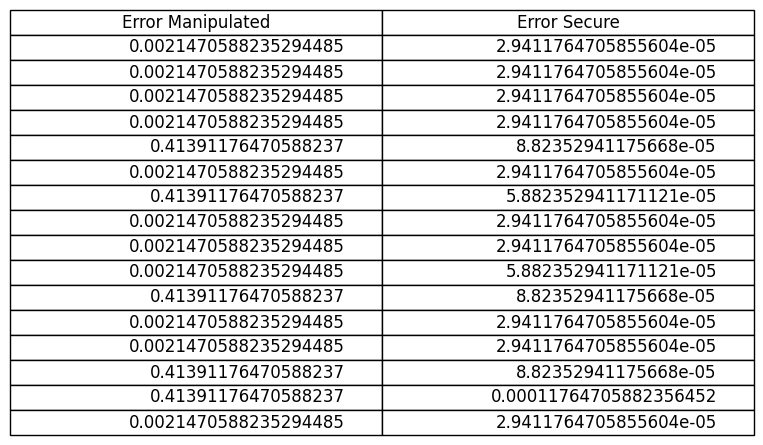

In [116]:
import matplotlib.pyplot as plt


# Creating a dictionary from the lists
data = {'Error Manipulated': error_manipulated, 'Error Secure': error_secured}

fig, ax = plt.subplots()
ax.axis('off')  # Hide axes

# Convert dictionary values to a list of lists
cell_text = list(data.values())

# Transpose the list to set columns as rows
cell_text = list(map(list, zip(*cell_text)))

# Get the keys of the dictionary as column labels
col_labels = list(data.keys())

table = ax.table(cellText=cell_text, colLabels=col_labels, loc='center')

# Modifying table properties (optional)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)  # Adjust table size if needed

plt.show()
